In [60]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/', one_hot = False)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [61]:
X_treinamento = mnist.train.images
y_treinamento = mnist.train.labels
X_teste = mnist.test.images
y_teste = mnist.test.labels

In [62]:
y_treinamento= np.asarray(y_treinamento, dtype = np.int32)
y_teste = np.asanyarray(y_teste, dtype=np.int32)

In [63]:
X_treinamento.shape
X_teste.shape

(10000, 784)

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
import tensorflow as tf

In [66]:
def cria_rede(features, labels, mode):
    #batch_size, largura, altura, canais
    entrada = tf.reshape(features['X'], [-1, 28, 28, 1])
    
    #recebe [batch_size, 28, 28, 1]
    #retorna [batch_size, 28, 28, 32]
    convolucao1 = tf.layers.conv2d(inputs = entrada, filters = 32, kernel_size=[5,5], activation=tf.nn.relu,
                                  padding = 'same')
    
    #recebe [batch_size, 28, 28, 32]
    #returna [batch_size, 14, 14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs = convolucao1, pool_size = [2,2], strides=2)
    
    #recebe [batch_size, 14, 14, 32]
    #retorna [batch_size, 14, 14, 64]
    convolucao2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size = [5,5], activation=tf.nn.relu,
                                  padding= 'same')
    
    #recebe [batch_size, 14, 14, 64]
    #retorna [batch_size, 7, 7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs = convolucao2, pool_size = [2,2], strides = 2)
    
    #recebe [batch_size, 7, 7, 64]
    #retorna [batch_size, 3136]
    flattening = tf.reshape(pooling2, [-1, 7*7*64])
    
    # 3136 -> 1024 -> 10
    #recebe [batch_size, 3136]
    #retorna [batch_size, 1024]
    densa = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)

    #dropout 
    dropout = tf.layers.dropout(inputs=densa, rate=0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    saida = tf.layers.dense(inputs = dropout, units = 10)
    
    previsoes = tf.argmax(saida, axis=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions = previsoes)
    
    erro= tf.losses.sparse_softmax_cross_entropy(labels = labels, logits= saida)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        otimizador = tf.train.AdamOptimizer(learning_rate=0.001)
        treinamento = otimizador.minimize(erro, global_step =tf.train.get_global_step())
    
        return tf.estimator.EstimatorSpec(mode = mode, loss = erro, train_op = treinamento)
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {'accuracy': tf.metrics.accuracy(labels=labels, predictions=previsoes)}
        return tf.estimator.EstimatorSpec(mode = mode, loss=erro, eval_metric_ops=eval_metric_ops)

In [67]:
classificador = tf.estimator.Estimator(model_fn=cria_rede)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp663oaeiq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f20fbad2630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [68]:
funcao_treinamento = tf.estimator.inputs.numpy_input_fn(x= {'X':X_treinamento}, y = y_treinamento, batch_size = 128,
                                                       num_epochs = None, shuffle = True)

classificador.train(input_fn=funcao_treinamento, steps = 200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp663oaeiq/model.ckpt.
INFO:tensorflow:loss = 2.2900476, step = 1
INFO:tensorflow:global_step/sec: 2.38267
INFO:tensorflow:loss = 0.08645612, step = 101 (41.969 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp663oaeiq/model.ckpt.
INFO:tensorflow:Loss for final step: 0.051254176.


In [69]:
funcao_teste = tf.estimator.inputs.numpy_input_fn(x = {'X': X_teste}, y = y_teste, num_epochs=1, shuffle=False)
resultados = classificador.evaluate(input_fn=funcao_teste)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-09T20:15:17Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp663oaeiq/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-09-20:15:22
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9782, global_step = 200, loss = 0.068124644
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmp663oaeiq/model.ckpt-200


In [70]:
X_imagem_teste = X_teste[0]
X_imagem_teste = X_imagem_teste.reshape(1,-1)
X_imagem_teste.shape

(1, 784)

In [71]:
funcao_previsao = tf.estimator.inputs.numpy_input_fn(x = {'X': X_imagem_teste}, shuffle = False)
pred = list(classificador.predict(input_fn=funcao_previsao))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp663oaeiq/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [72]:
pred

[7]

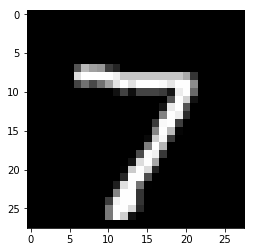

In [74]:
plt.imshow(X_imagem_teste.reshape((28,28)), cmap='gray')